In [1]:
# import libraries
from cil.optimisation.functions import L1Norm, MixedL21Norm, BlockFunction, ZeroFunction
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator
from cil.optimisation.algorithms import LADMM, PDHG
from cil.framework import ImageGeometry
from cil.utilities.dataexample import TestData
from cil.utilities.display import plotter2D
from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
import numpy as np

import os, sys

from PIL import Image

In [2]:
loader = TestData(data_dir=os.path.join(sys.prefix, 'share','cil'))
data = loader.load(TestData.RAINBOW)
ig = data.geometry

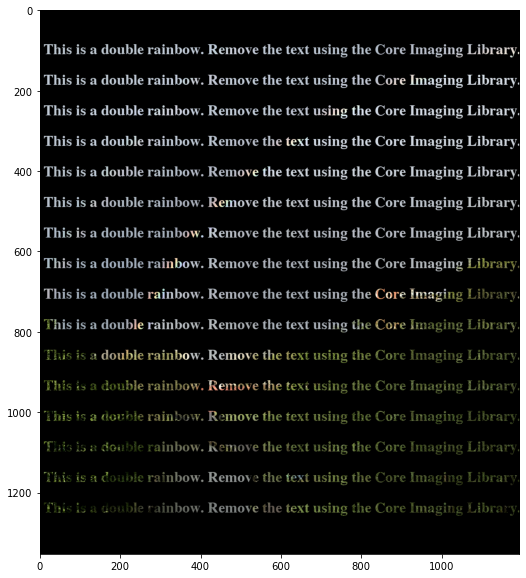

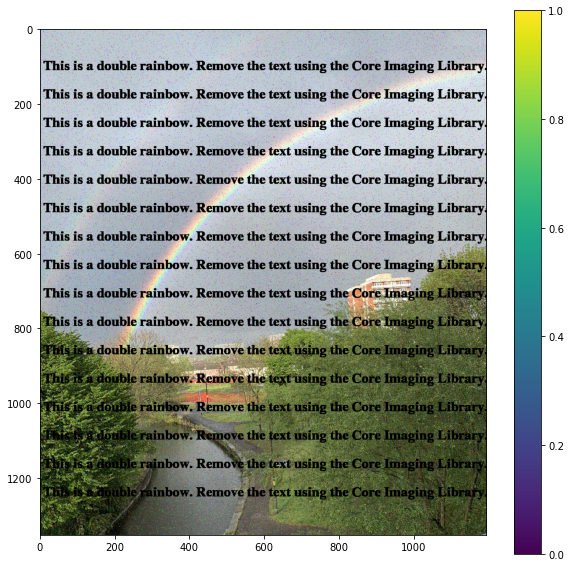

/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/optimisation/operators/GradientOperator.py:84: UserWarning: Warning: correlation='Space' on multi-channel dataset will use `numpy` backend
  warnings.warn("Warning: correlation='Space' on multi-channel dataset will use `numpy` backend")


Initialised GradientOperator with numpy backend
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       2000         0.000    2.46081e+06  -0.00000e+00    2.46081e+06


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


KeyboardInterrupt: 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from cil.optimisation.functions import TotalVariation
from cil.framework import ImageGeometry
from cil.utilities.dataexample import TestData
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

from cil.optimisation.operators import MaskOperator, BlockOperator, SymmetrisedGradientOperator, \
                                GradientOperator, ZeroOperator, IdentityOperator, ChannelwiseOperator

from cil.optimisation.functions import ZeroFunction, L1Norm, \
                      MixedL21Norm, BlockFunction
from cil.optimisation.algorithms import PDHG

# Edit path to image
path_to_image = "/media/newhd/shared/ReproducePapers/CIL2/CIL-data/"

# Load "Rainbow" image
im = np.array(Image.open(path_to_image + "rainbow.png").convert('RGB'))
im = im/im.max()
ig = ImageGeometry(voxel_num_x=im.shape[0], voxel_num_y=im.shape[1], channels=im.shape[2], 
                    dimension_labels=[ImageGeometry.HORIZONTAL_X, ImageGeometry.HORIZONTAL_Y, ImageGeometry.CHANNEL])
data = ig.allocate() 
data.fill(im)

# Create inpainted image
tmp = Image.open(path_to_image + "rainbow.png").convert('RGB')
text = "\n\n This is a double rainbow. Remove the text using the Core Imaging Library."*16
draw = ImageDraw.Draw(tmp)
font = ImageFont.truetype('FreeSerifBold.ttf', 37)
draw.text((0, 0), text, (0, 0, 0), font=font)

im1 = np.array(tmp)
im1 = im1/im1.max()
ig1 = ig.clone()
data1 = ig1.allocate()
data1.fill(im1)

# Create mask from corrupted image and apply MaskOperator channelwise
tmp_mask_array = np.abs(im1 - im)
plt.figure(figsize=(10,10))
plt.imshow(tmp_mask_array, cmap ='inferno')
plt.show()

tmp = (data1-data).abs()==0
mask2D = tmp[:,:,0]

mask = ig.subset(channel=0).allocate(True,dtype=np.bool)
mask.fill(mask2D)
MO = ChannelwiseOperator(MaskOperator(mask),3, dimension = 'append')

# Add salt and pepper noise
n1 = TestData.random_noise(data.as_array(), mode = 's&p', amount=0.03, seed = 10)
noisy_data = ig.allocate()
noisy_data.fill(n1)

noisy_data = MO.direct(noisy_data) 

plt.figure(figsize=(10,10))
plt.imshow(noisy_data.as_array())
plt.colorbar()
plt.show()

# Setup PDHG for TGV regularisation
alpha = 0.5
beta = 0.2

# Define BlockFunction f
f2 = alpha * MixedL21Norm()
f3 = beta * MixedL21Norm() 
f1 = L1Norm(b=noisy_data)
f = BlockFunction(f1, f2, f3)         

# Define function g 
g = ZeroFunction()

# Define BlockOperator K
K11 = MO
K21 = GradientOperator(ig)
K32 = SymmetrisedGradientOperator(K21.range)
K12 = ZeroOperator(K32.domain, ig)
K22 = IdentityOperator(K21.range)
K31 = ZeroOperator(ig, K32.range)
K = BlockOperator(K11, -K12, K21, K22, K31, K32, shape=(3,2) )

# Compute operator Norm
normK = K.norm()

# Setup and run the PDHG algorithm
pdhg = PDHG(f=f,g=g,operator=K,
            max_iteration = 2000,
            update_objective_interval = 500)
pdhg.run(verbose = 2)      

# show ground truth, noisy data and reconstruction
all_im = [data, noisy_data, pdhg.get_output()[0]]

for i in range(len(all_im)):
    plt.figure(figsize=(15,18))    
    plt.axis('off')
    ax = plt.gca()
    tmp = ax.imshow(all_im[i].as_array())
plt.show() 






In [4]:
# Load an image from the CIL gallery. 
path_to_image = "../../CIL-data/"

# Open "Rainbow image" and create an ImageGeometry
im = np.array(Image.open(path_to_image + "rainbow.png").convert('RGB'))
im = im/im.max()
ig = ImageGeometry(voxel_num_x=im.shape[0], voxel_num_y=im.shape[1], channels=im.shape[2], 
                    dimension_labels=[ImageGeometry.HORIZONTAL_X, ImageGeometry.HORIZONTAL_Y, ImageGeometry.CHANNEL])
                  
data = ig.allocate() 
data.fill(im)

FileNotFoundError: [Errno 2] No such file or directory: '../../CIL-data/rainbow.png'

In [5]:
# Add gaussian noise
noisy_data = TestData.random_noise(data, mode = 's&p', amount=0.1, seed = 10)

In [6]:
# -*- coding: utf-8 -*-
#  CCP in Tomographic Imaging (CCPi) Core Imaging Library (CIL).

#   Copyright 2017-2020 UKRI-STFC
#   Copyright 2017-2020 University of Manchester

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

from cil.optimisation.algorithms import Algorithm
import warnings

class LADMM(Algorithm):
        
    ''' 
        LADMM is the Linearized Alternating Direction Method of Multipliers (LADMM)
    
        General form of ADMM : min_{x} f(x) + g(y), subject to Ax + By = b
    
        Case: A = Id, B = -K, b = 0   ==> min_x f(Kx) + g(x)  
                
        The quadratic term in the augmented Lagrangian is linearized for the x-update.
                            
        Main algorithmic difference is that in ADMM we compute two proximal subproblems, 
        where in the PDHG a proximal and proximal conjugate.

        Reference (Section 8) : https://link.springer.com/content/pdf/10.1007/s10107-018-1321-1.pdf                          

            x^{k} = prox_{\tau f } (x^{k-1} - tau/sigma A^{T}(Ax^{k-1} - z^{k-1} + u^{k-1} )                
            
            z^{k} = prox_{\sigma g} (Ax^{k} + u^{k-1})
            
            u^{k} = u^{k-1} + Ax^{k} - z^{k}
                
    '''

    def __init__(self, f=None, g=None, operator=None, \
                       tau = None, sigma = 1., 
                       initial = None, use_axpby=True, **kwargs):
        
        '''Initialisation of the algorithm

        :param operator: a Linear Operator
        :param f: Convex function with "simple" proximal
        :param g: Convex function with "simple" proximal 
        :param sigma: Positive step size parameter 
        :param tau: Positive step size parameter
        :param initial: Initial guess ( Default initial_guess = 0)'''        
        
        super(LADMM, self).__init__(**kwargs)
        if kwargs.get('x_init', None) is not None:
            if initial is None:
                warnings.warn('The use of the x_init parameter is deprecated and will be removed in following version. Use initial instead',
                   DeprecationWarning, stacklevel=4)
                initial = kwargs.get('x_init', None)
            else:
                raise ValueError('{} received both initial and the deprecated x_init parameter. It is not clear which one we should use.'\
                    .format(self.__class__.__name__))

        self.set_up(f = f, g = g, operator = operator, tau = tau,\
             sigma = sigma, initial=initial)        
        
        self._use_axpby = use_axpby
        
    def set_up(self, f, g, operator, tau = None, sigma=1., \
        initial=None):

        print("{} setting up".format(self.__class__.__name__, ))
        
        if sigma is None and tau is None:
            raise ValueError('Need tau <= sigma / ||K||^2')

        self.f = f
        self.g = g
        self.operator = operator

        self.tau = tau
        self.sigma = sigma

        if self.tau is None:
            normK = self.operator.norm()
            self.tau = self.sigma / normK ** 2
            
        if initial is None:
            self.x = self.operator.domain_geometry().allocate()
        else:
            self.x = initial.copy()
         
        # allocate space for operator direct & adjoint    
        self.tmp_dir = self.operator.range_geometry().allocate()
        self.tmp_adj = self.operator.domain_geometry().allocate()            
            
        self.z = self.operator.range_geometry().allocate() 
        self.u = self.operator.range_geometry().allocate() 

        self.configured = True  
        
        print("{} configured".format(self.__class__.__name__, ))
        
    def update(self):

        self.tmp_dir += self.u
        self.tmp_dir -= self.z                   
        self.operator.adjoint(self.tmp_dir, out = self.tmp_adj)          
        
        # axpby      
        if self._use_axpby:
            self.x.axpby(1 , -self.tau/self.sigma, self.tmp_adj, out=self.x)
        else:
            self.tmp_adj *= -self.tau/self.sigma
            self.x += self.tmp_adj             
                    
        # apply proximal of f        
        self.f.proximal(self.x, self.tau, out = self.x)
        
        self.operator.direct(self.x, out = self.tmp_dir)  
        self.u += self.tmp_dir
        
        # apply proximal of g   
        self.g.proximal(self.u, self.sigma, out = self.z)

        # update 
        self.u += self.tmp_dir
        self.u -= self.z

    def update_objective(self):
        
        self.loss.append(self.f(self.x) +  self.g(self.operator.direct(self.x)) )                 

In [8]:
alpha = 0.8

K = GradientOperator(ig)
G = alpha * MixedL21Norm()
F = L1Norm(b=noisy_data)

# Compute operator Norm
normK = K.norm()

# Primal & dual stepsizes 
sigma = 5.
tau = 1. / normK ** 2 

# Setup and run the PDHG algorithm
admm = LADMM(f=F, g=G, operator=K, sigma = sigma, tau = tau,
                 max_iteration = 1000, update_objective_interval=100, use_axpby=False)
admm.run(verbose = 1)

Initialised GradientOperator with numpy backend
LADMM setting up
LADMM configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          2.79675e+06
      100       1000         0.218          3.49272e+05
      200       1000         0.218          3.45777e+05
      300       1000         0.217          3.45313e+05
      400       1000         0.217          3.45168e+05
      500       1000         0.217          3.45055e+05
      600       1000         0.217          3.44957e+05
      700       1000         0.217          3.44892e+05
      800       1000         0.218          3.44842e+05
      900       1000         0.218          3.44815e+05
     1000       1000         0.218          3.44798e+05
-------------------------------------------------------
     1000       1000         0.218          3.44798e+05
Stop criterion has been reached.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


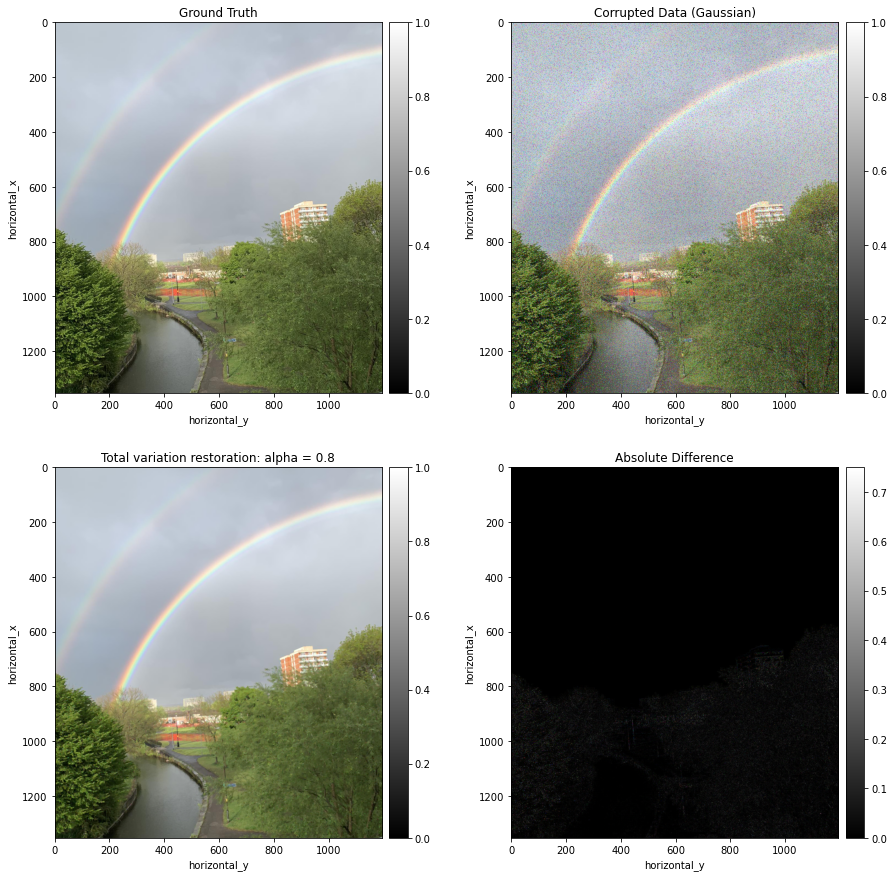

In [6]:
plotter2D([data, noisy_data, admm.solution, (admm.solution-data).abs()],
          titles=["Ground Truth", 
                  "Corrupted Data (Gaussian)", 
                  "Total variation restoration: alpha = {}".format(alpha),
                  "Absolute Difference"],
         origin = "upper")

In [31]:
class MyClass:
    def method(self):
        return 'instance method called', self

    @classmethod
    def classmethod(cls):
        return 'class method called', cls

    @staticmethod
    def staticmethod():
        return 'static method called'

In [32]:
obj = MyClass()
obj.method()

('instance method called', <__main__.MyClass at 0x7f52a8e80050>)